# Lab-03 Q3 Knowledge Distillation

Please run the code with "VScode-devcontainer".

It is easier to use Git in local.

In [17]:
# install requirements
#
# !pip install pytorchcv torchinfo
# !wget -P data/cifar10_1 https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v6_labels.npy
# !wget -P data/cifar10_1 https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v6_data.npy

# Import Required Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from pathlib import Path
import torch.nn as nn
import numpy as np
from pytorchcv.model_provider import get_model
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from utils import Cifar10_1

# Define Hyper Parameters

In [3]:
DATA_PATH = "./data"

# change these hyper parameter if needed
BATCH_SIZE = 32
EPOCH = 10

NUM_CLASSES = 10
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

# check device (CPU, GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load Dataset & Augmentation
Reference: https://pytorch.org/vision/master/transforms.html

In [54]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [58]:
# load dataset : CIFAR-10 ( Shape : size * 32 * 32 * 3 )

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset_1 = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testset_2 = Cifar10_1(root="./data/cifar10_1/", transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Model Implementation

Reference:  

- AlexNet
    - https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py
- NIN
    - https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/models/nin_cifar.py

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [65]:
# get_model(name=student_model_name + "_cifar10", pretrained=True)


class NINConv(nn.Module):
    """
    NIN specific convolution block.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(NINConv, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=True,
        )
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activ(x)
        return x


class CIFARNIN(nn.Module):
    def __init__(self, channels, first_kernel_sizes, in_channels=3, in_size=(32, 32), num_classes=10):
        super(CIFARNIN, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                if (j == 0) and (i != 0):
                    if i == 1:
                        stage.add_module(
                            "pool{}".format(i + 1),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                        )
                    else:
                        stage.add_module(
                            "pool{}".format(i + 1),
                            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
                        )
                    stage.add_module("dropout{}".format(i + 1), nn.Dropout(p=0.5))
                kernel_size = first_kernel_sizes[i] if j == 0 else 1
                padding = (kernel_size - 1) // 2
                stage.add_module(
                    "unit{}".format(j + 1),
                    NINConv(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        padding=padding,
                    ),
                )
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)

        self.output = nn.Sequential()
        self.output.add_module(
            "final_conv",
            NINConv(in_channels=in_channels, out_channels=num_classes, kernel_size=1),
        )
        self.output.add_module("final_pool", nn.AvgPool2d(kernel_size=8, stride=1))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_nin_cifar(num_classes, model_name=None, pretrained=False, **kwargs):
    channels = [[192, 160, 96], [192, 192, 192], [192, 192]]
    first_kernel_sizes = [5, 5, 3]

    net = CIFARNIN(
        channels=channels,
        first_kernel_sizes=first_kernel_sizes,
        num_classes=num_classes,
        **kwargs
    )

    return net


def nin_cifar10(num_classes=10, **kwargs):
    return get_nin_cifar(num_classes=num_classes, model_name="nin_cifar10", **kwargs)

In [43]:
class SoftmaxTemperatureLayer(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature

    def forward(self, x):
        logits = x / self.temperature
        probabilities = nn.functional.softmax(logits, dim=-1)
        return probabilities

# Get model
Reference:   
https://pytorch.org/tutorials/beginner/saving_loading_models.html  

In [61]:
# Load Teacher Model
teacher_model_name = "AlexNet"
teacher_model = AlexNet(NUM_CLASSES).to(device)

teacher_model_param_UUID = 1
teacher_model.load_state_dict(torch.load(f"./model/model_{teacher_model_param_UUID}.pth"))
# teacher_model = nn.Sequential(teacher_model, SoftmaxTemperatureLayer(temperature=1.0))
teacher_model.eval()
print(f"Loaded teacher model parameters: model_{teacher_model_param_UUID}.pth")

# Load Student Model
student_model_name = "nin"
student_model = nin_cifar10(pretrained=False)
student_model = nn.Sequential(student_model, SoftmaxTemperatureLayer(temperature=1.0))
student_model.eval()
student_model = student_model.to(device)

# Choose loss function
LOSS_FUNCTION = "CrossEntropy"

Loaded teacher model parameters: model_1.pth


In [38]:
print("Teacher model :")
summary(teacher_model, input_size=(1, 3, 224, 224), device=device)

Teacher model :


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─AlexNet: 1-1                           [1, 10]                   --
│    └─Sequential: 2-1                   [1, 256, 6, 6]            --
│    │    └─Conv2d: 3-1                  [1, 64, 55, 55]           23,296
│    │    └─ReLU: 3-2                    [1, 64, 55, 55]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 27, 27]           --
│    │    └─Conv2d: 3-4                  [1, 192, 27, 27]          307,392
│    │    └─ReLU: 3-5                    [1, 192, 27, 27]          --
│    │    └─MaxPool2d: 3-6               [1, 192, 13, 13]          --
│    │    └─Conv2d: 3-7                  [1, 384, 13, 13]          663,936
│    │    └─ReLU: 3-8                    [1, 384, 13, 13]          --
│    │    └─Conv2d: 3-9                  [1, 256, 13, 13]          884,992
│    │    └─ReLU: 3-10                   [1, 256, 13, 13]         

In [62]:
print("Student model :")
summary(student_model, input_size=(1, 3, 32, 32), device=device)

Student model :


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─CIFARNIN: 1-1                          [1, 10]                   --
│    └─Sequential: 2-1                   [1, 192, 8, 8]            --
│    │    └─Sequential: 3-1              [1, 96, 32, 32]           60,928
│    │    └─Sequential: 3-2              [1, 192, 16, 16]          535,104
│    │    └─Sequential: 3-3              [1, 192, 8, 8]            369,024
│    └─Sequential: 2-2                   [1, 10, 1, 1]             --
│    │    └─NINConv: 3-4                 [1, 10, 8, 8]             1,930
│    │    └─AvgPool2d: 3-5               [1, 10, 1, 1]             --
├─SoftmaxTemperatureLayer: 1-2           [1, 10]                   --
Total params: 966,986
Trainable params: 966,986
Non-trainable params: 0
Total mult-adds (M): 223.12
Input size (MB): 0.01
Forward/backward pass size (MB): 5.05
Params size (MB): 3.87
Estimated Total Size (MB)

# Test single data

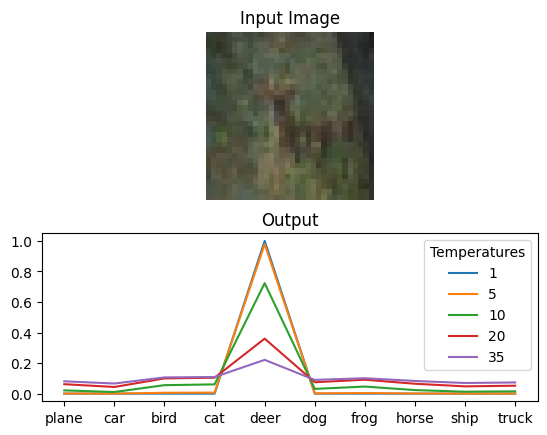

In [67]:
item_idx = 10
figure = plt.figure()

# Get image
item_image = trainset.data[item_idx]
subplot = figure.add_subplot(2, 1, 1)
subplot.axis("off")
subplot.title.set_text("Input Image")  # type: ignore
subplot.imshow(item_image)

# Image Preprocessing
item_image = Image.fromarray(item_image)
item_image = transform(item_image)
item_image = torch.unsqueeze(item_image, dim=0)  # type: ignore

# Get model output
teacher_model.eval()
item_image = item_image.to(device)
output = teacher_model(item_image)

# Apply temperature & Show Output
temperatures = [1, 5, 10, 20, 35]
subplot = figure.add_subplot(2, 1, 2)
for temperature in temperatures:
    softmax_temperature = torch.softmax(output / temperature, dim=1)
    subplot.plot(classes, softmax_temperature[0].cpu().detach().numpy())
subplot.title.set_text("Output")  # type: ignore
subplot.legend(temperatures, title="Temperatures")

# Version Control

In [17]:
UUID = 1

hyperparameter_log = {
    "UUID": UUID,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCH": EPOCH,
    "MODEL_NAME": teacher_model_name,
    "LOSS_FUNCTION": LOSS_FUNCTION,
    "DEVICE": device.type,
}

print(hyperparameter_log)

{'UUID': 1, 'BATCH_SIZE': 32, 'EPOCH': 10, 'MODEL_NAME': 'AlexNet', 'LOSS_FUNCTION': 'CrossEntropy', 'DEVICE': 'cuda'}


# Training Model

In [18]:
# dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader_1 = DataLoader(
    testset_1, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)
testloader_2 = DataLoader(
    testset_2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

In [42]:
# define loss function
# https://blog.csdn.net/weixin_36670529/article/details/105670337
if LOSS_FUNCTION == "CrossEntropy":
    criterion = nn.CrossEntropyLoss()
elif LOSS_FUNCTION == "MSE":
    criterion = nn.MSELoss()

# or define your own loss function here
# https://discuss.pytorch.org/t/custom-loss-functions/29387
# https://rowantseng.medium.com/pytorch-%E8%87%AA%E5%AE%9A%E7%BE%A9%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-custom-loss-c12e8741968b
# https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/
# 😂

# Do not modify this
optimizer = optim.SGD(teacher_model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
# train
def train(e):
    teacher_model.train()
    num_data = 0
    correct = 0
    loss_all = 0

    for i, (x, y) in enumerate(tqdm(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        x, y = x.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = teacher_model(x)

        # compute loss here
        loss = criterion(outputs, y)

        # L2 Regularization
        # Reference: https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/
        l2_lambda = 0.00005
        l2_norm = sum(param.pow(2.0).sum() for param in teacher_model.parameters())
        loss += l2_lambda * l2_norm

        # back prop
        loss.backward()
        optimizer.step()

        # log
        num_data += y.size(0)
        loss_all += loss.item()
        pred = outputs.data.max(1)[1]
        correct += pred.eq(y.view(-1)).sum().item()

    print(
        f"epoch: [{e}], loss: {loss_all/len(trainloader):.4f}, acc: {correct/num_data:.4f}"
    )


# start training
for e in range(EPOCH):
    train(e)

In [30]:
# evaluate
def test(model, test_loader, loss_fun, device):
    model.eval()
    test_loss = 0
    correct = 0
    targets = []

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device).long()

        targets.append(target.detach().cpu().numpy())

        output = model(data)

        test_loss += loss_fun(output, target).item()
        pred = output.data.max(1)[1]

        correct += pred.eq(target.view(-1)).sum().item()

    return test_loss / len(test_loader), correct / len(test_loader.dataset)


loss, acc = test(teacher_model, testloader_1, criterion, device)
print(f"on testset 1: loss: {loss:.4f}, acc: {acc:.4f}")

loss, acc = test(teacher_model, testloader_2, criterion, device)
print(f"on testset 2: loss: {loss:.4f}, acc: {acc:.4f}")

on testset 1: loss: 0.6890, acc: 0.8681
on testset 2: loss: 1.4122, acc: 0.7620


# Save the model & Results

In [31]:
torch.save(teacher_model.state_dict(), f"./model/model_student_{UUID}.pth")

In [32]:
# record the results to a log file (e.g google sheet, )